# Aqualab Validation Study: High-Level Review

Up until this point most of our analysis in the validation study has been strictly stats-focused: p-values/logits/alpha etc. Now that we have some basic features that have been identified as potentially meaningful in the context of this study, let's expand the breadth of our analysis to take into account the actual content of significant jobs.

## Initial Overview



*   Binary explanatory, ordinal response variable
*   Logit models
*   Most p-values retained even with benjamini-hochberg method filtering
*   Binary and quartile buckets yield promising results

### General Process

1.   Bucket ordinal EMA data into either binary or quartile buckets
2.   Calculate the point-biserial coefficients for all possible combinations of per-job features and the three evaluation, modeling, and argumentation scores
3.   Filter for all coefficients with a p-value below a=0.05
4.   Further filter p-values with benjamini-hochberg procedure, keeping in mind that our initial coefficient calculation is looking at a max m=171(57 jobs against 3 E/M/A values)
5. Run logistic regression models against all job and EMA correlations.
6. Models with a p-value below 0.05 and a correlation coeff(or in this case odds-ratio) above 1 are significant.


Let's do a join on significant jobs and their corresponding EMA measures, and see what that tells us.

## Basic data loading/previs

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!pip install rfpimp
!pip install mord
!pip install pypair
!pip install phik
!pip install MASS

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import pointbiserialr

from phik.report import plot_correlation_matrix
from sklearn.metrics import confusion_matrix

from scipy.stats import kendalltau

import scipy.stats as stats
import statistics

import sklearn
from statsmodels.miscmodels.ordinal_model import OrderedModel
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as LR
from sklearn.linear_model import Perceptron
import statsmodels.formula.api as smf
from sklearn.linear_model import LogisticRegression
from sklearn import tree
import graphviz

from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import make_scorer,recall_score, roc_curve, roc_auc_score
from tensorflow import keras
from sklearn import linear_model
from scipy.stats import chi2


import statsmodels.api as sm

import rfpimp
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr
from pypair.association import binary_continuous


import json
import urllib.request as ur
from collections import Counter
from io import BytesIO
from math import ceil, pi
from pathlib import Path
from pprint import pprint
from zipfile import ZipFile
from mord import LogisticAT

import statsmodels.api as sm

Mounted at /content/drive
  Preparing metadata (setup.py) ... done
  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10649 sha256=abf9a3fbc3906c133d43e821b61559a8be59da33b2cab961c91cc6a419003055
  Stored in directory: /root/.cache/pip/wheels/6a/12/08/d5bc35127c8d69d39c1f3736a95419ab4763cc0c80ed65bf41
Successfully built rfpimp
  Preparing metadata (setup.py) ... done
  Created wheel for mord: filename=mord-0.7-py3-none-any.whl size=9885 sha256=fda6a96ebce04d3540ba730896546a0f82af3f4525271977318064b999e80eff
  Stored in directory: /root/.cache/pip/wheels/77/00/19/3cea86fbfc737ec4acb515cd94497dcc33f943fa157548b96c
Successfully built mord
  Preparing metadata (setup.py) ... done
  Created wheel for pypair: filename=pypair-3.0.9-py3-none-any.whl size=24526 sha256=0d0289924ba3cc282ad1d29d57cafc7be29b87d03ec7a37e112aeb825dabac19
  Stored in directory: /root/.cache/pip/wheels/27/d8/78/bc27988fe8ef1086879ea558f8c9bc03d8c51e4ff2c1ee8344
Successfully built pypair
     ━━━━━━

In [ ]:
## Load in feature values and columns from tsv

ply_features = pd.read_csv("/content/drive/MyDrive/AqualabValidation_Zach/featuredata/AQUALAB_20220601_to_20220715_c2ad3af_player-features.tsv", sep = "	").dropna()
#remove NA values
ply_features = ply_features.loc[ply_features.PlayerID.isna() != True]

id_col = ['PlayerID']
job_col = []
aggr_col = []
for col in ply_features.columns:
  pieces = col.split('_')
  prefix = pieces[0]
  if prefix.startswith('job'):
    job_col.append(pieces[1])
  else:
    aggr_col.append(col)
job_col = Counter(job_col)
print(f"{len(ply_features.columns)} perjobfeatures in {len(job_col)} groups:")
pprint(job_col, compact=False)

job_col = [key for key in job_col.keys() if key.startswith('Job')]
aggr_col = aggr_col[1:]
pprint(aggr_col)


1272 perjobfeatures in 22 groups:
Counter({'JobActiveTime': 57,
         'JobArgumentationTime': 57,
         'JobCompletionTime': 57,
         'JobDiveSitesCount': 57,
         'JobDiveTime': 57,
         'JobExperimentationTime': 57,
         'JobGuideCount': 57,
         'JobHelpCount': 57,
         'JobHelpCount-ByTask': 57,
         'JobLocationChanges': 57,
         'JobLocationChanges-ByTask': 57,
         'JobModelingTime': 57,
         'JobTasksCompleted': 57,
         'SyncCompletionTime': 57,
         'JobsAttempted': 57,
         'JobsAttempted-job-name': 57,
         'JobsAttempted-num-starts': 57,
         'JobsAttempted-num-completes': 57,
         'JobsAttempted-percent-complete': 57,
         'JobsAttempted-avg-time-per-attempt': 57,
         'JobsAttempted-std-dev-per-attempt': 57,
         'JobsAttempted-job-difficulties': 57})
['ActiveTime',
 'JobsCompleted',
 'SessionDiveSitesCount',
 'SessionDuration',
 'SessionGuideCount',
 'SessionHelpCount',
 'SessionID',
 'Ses

In [ ]:
# import job complexity scores
DBexport = json.load(open("/content/drive/MyDrive/AqualabValidation_Zach/DBExport.json"))
Complexity_df = pd.DataFrame(columns=['job_id', 'job_name', 'argumentation', 'experimentation', 'modeling'])
for id, job in enumerate(DBexport.get('jobs')):
  Complexity_df.loc[len(Complexity_df.index)] = [id, job['id'], job['difficulties']['argumentation'],
                                                 job['difficulties']['experimentation'],
                                                 job['difficulties']['modeling']]

# import player complexity scores
labels = pd.read_excel("/content/drive/MyDrive/AqualabValidation_Zach/surveydata/Aqualab Practices Survey June 2022 scores final.xlsx",
                       sheet_name='Simplified')
labels = labels.rename({'Modeling_score_max_5)':'Modeling_score_max_5'}, axis='columns')

player_complexity = pd.merge(ply_features, labels, left_on="PlayerID", right_on="user_code", how="inner")


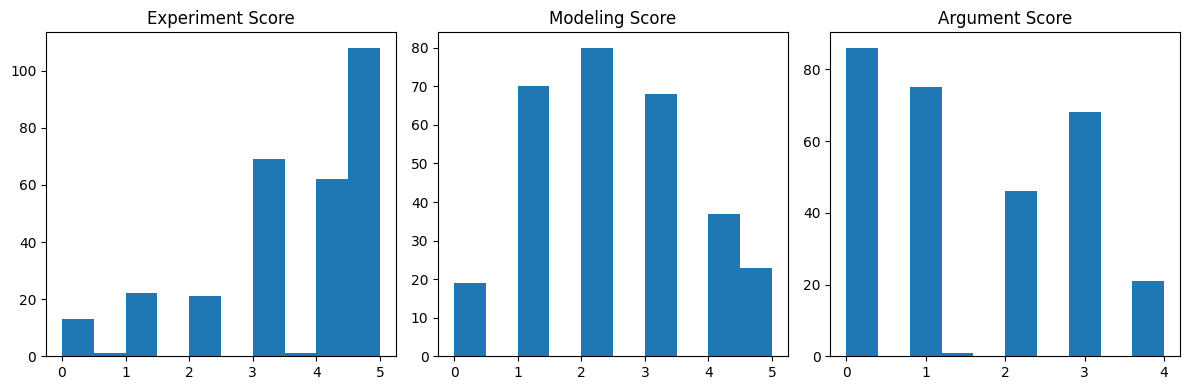

,Experiment_score_max_5,Modeling_score_max_5,Argument_score_max_4
count,297.000000,297.000000,297.000000
mean,3.580161,2.349586,1.538478
std,1.453780,1.339584,1.308179
min,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000
50%,4.000000,2.000000,1.000000
75%,5.000000,3.000000,3.000000
max,5.000000,5.000000,4.000000


In [ ]:
experiment_score = labels['Experiment_score_max_5']
modeling_score = labels['Modeling_score_max_5']
argument_score = labels['Argument_score_max_4']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].hist(experiment_score)
axes[0].set_title('Experiment Score')
axes[1].hist(modeling_score)
axes[1].set_title('Modeling Score')
axes[2].hist(argument_score)
axes[2].set_title('Argument Score')

plt.tight_layout()

plt.show()


labels.describe()

In [ ]:
player_complexity['Experiment_score_max_5'] = player_complexity['Experiment_score_max_5'].round().astype(int)
player_complexity['Modeling_score_max_5'] = player_complexity['Modeling_score_max_5'].round().astype(int)
player_complexity['Argument_score_max_4'] = player_complexity['Argument_score_max_4'].round().astype(int)

print(player_complexity['Experiment_score_max_5'].value_counts())
print(player_complexity['Modeling_score_max_5'].value_counts())
print(player_complexity['Argument_score_max_4'].value_counts())

5    59
3    47
4    33
2    13
1    13
0     4
Name: Experiment_score_max_5, dtype: int64
1    47
2    47
3    31
4    22
5    12
0    10
Name: Modeling_score_max_5, dtype: int64
1    51
0    48
3    38
2    22
4    10
Name: Argument_score_max_4, dtype: int64


In [ ]:
df = player_complexity

# Create new column for 'Modeling_score_max_5'
df['Modeling_score_max_5_binary_bucket_2'] = df['Modeling_score_max_5'].apply(lambda x: 0 if x < statistics.median(df['Modeling_score_max_5']) else 1)

# Create new column for 'Argument_score_max_4'
df['Argument_score_max_4_binary_bucket_2'] = df['Argument_score_max_4'].apply(lambda x: 0 if x < statistics.median(df['Argument_score_max_4']) else 1)

# Create new column for 'Experiment_score_max_5'
df['Experiment_score_max_5_binary_bucket_2'] = df['Experiment_score_max_5'].apply(lambda x: 0 if x < statistics.median(df['Experiment_score_max_5']) else 1)

####################
df['Modeling_score_max_5_binary_bucket_3'] = df['Modeling_score_max_5'].apply(lambda x: 0 if x < np.percentile(df['Modeling_score_max_5'], 75) else 1)

# Create new column for 'Argument_score_max_4'
df['Argument_score_max_4_binary_bucket_3'] = df['Argument_score_max_4'].apply(lambda x: 0 if x < np.percentile(df['Argument_score_max_4'], 75) else 1)

# Create new column for 'Experiment_score_max_5'
df['Experiment_score_max_5_binary_bucket_3'] = df['Experiment_score_max_5'].apply(lambda x: 0 if x < np.percentile(df['Experiment_score_max_5'], 75) else 1)


########################
df['Modeling_score_max_5_bucket_4'] = df['Modeling_score_max_5'].apply(lambda x: 0 if x < np.percentile(df['Modeling_score_max_5'], 25) else (1 if x < np.percentile(df['Modeling_score_max_5'], 50) else (2 if x < np.percentile(df['Modeling_score_max_5'], 75) else 3)))

# Create new column for 'Argument_score_max_4'
df['Argument_score_max_4_bucket_4'] = df['Argument_score_max_4'].apply(lambda x: 0 if x < np.percentile(df['Argument_score_max_4'], 25) else (1 if x < np.percentile(df['Argument_score_max_4'], 50) else (2 if x < np.percentile(df['Argument_score_max_4'], 75) else 3)))

# Create new column for 'Experiment_score_max_5'
df['Experiment_score_max_5_bucket_4'] = df['Experiment_score_max_5'].apply(lambda x: 0 if x < np.percentile(df['Experiment_score_max_5'], 25) else (1 if x < np.percentile(df['Experiment_score_max_5'], 50) else (2 if x < np.percentile(df['Experiment_score_max_5'], 75) else 3)))

<ipython-input-7-65277f1397e7>:4: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Modeling_score_max_5_binary_bucket_2'] = df['Modeling_score_max_5'].apply(lambda x: 0 if x < statistics.median(df['Modeling_score_max_5']) else 1)
<ipython-input-7-65277f1397e7>:7: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Argument_score_max_4_binary_bucket_2'] = df['Argument_score_max_4'].apply(lambda x: 0 if x < statistics.median(df['Argument_score_max_4']) else 1)
<ipython-input-7-65277f1397e7>:10: PerformanceWarning: DataFrame is high

## Bucketing:

For now, let's use a binary bucket that separates our EMA outcomes at the 75th percentile. This gives us greater uniformity in our distributions across all three metrics.

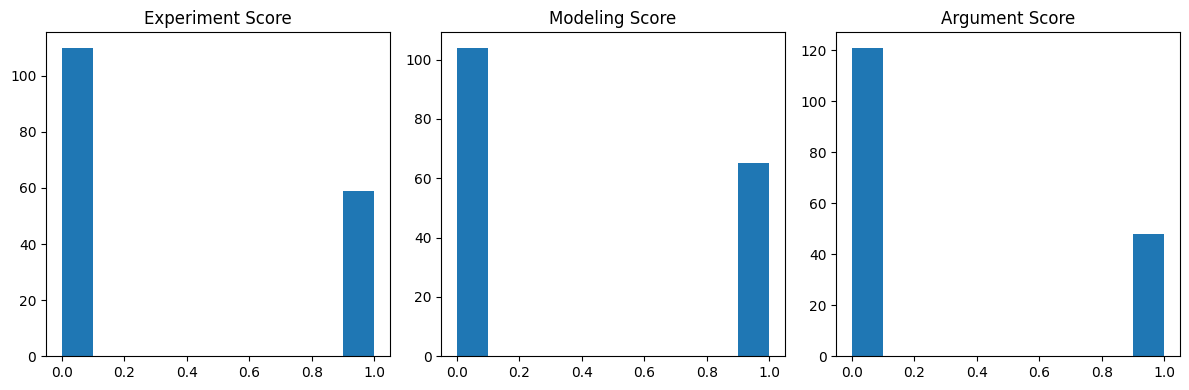

,Experiment_score_max_5,Modeling_score_max_5,Argument_score_max_4
count,297.000000,297.000000,297.000000
mean,3.580161,2.349586,1.538478
std,1.453780,1.339584,1.308179
min,0.000000,0.000000,0.000000
25%,3.000000,1.000000,0.000000
50%,4.000000,2.000000,1.000000
75%,5.000000,3.000000,3.000000
max,5.000000,5.000000,4.000000


In [ ]:
experiment_score = df['Experiment_score_max_5_binary_bucket_3']
modeling_score = df['Modeling_score_max_5_binary_bucket_3']
argument_score = df['Argument_score_max_4_binary_bucket_3']

fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].hist(experiment_score)
axes[0].set_title('Experiment Score')
axes[1].hist(modeling_score)
axes[1].set_title('Modeling Score')
axes[2].hist(argument_score)
axes[2].set_title('Argument Score')

plt.tight_layout()

plt.show()


labels.describe()

## Calculating point-biserial coefficients

In [ ]:

correlation_columns = ['Experiment_score_max_5_binary_bucket_3', 'Modeling_score_max_5_binary_bucket_3', 'Argument_score_max_4_binary_bucket_3']

for job in df:
  if "JobTasksCompleted" in job:
    df[job] = df[job].map(lambda x: 1 if x != 0 else x)
    for corr in correlation_columns:
      pbs = stats.pointbiserialr(df[corr], df[job])
      if pbs.pvalue < 0.05 and pbs.statistic > 0.2: #benjamini hochberg to adjust alpha
        print(f'{job}: {pbs.statistic}, {pbs.pvalue}, {corr}')

job12_JobTasksCompleted: 0.2867507795491595, 0.0001569653465884487, Argument_score_max_4_binary_bucket_3
job13_JobTasksCompleted: 0.28694893612833045, 0.00015525478511295868, Argument_score_max_4_binary_bucket_3
job32_JobTasksCompleted: 0.22468922637101446, 0.0033147995435681807, Modeling_score_max_5_binary_bucket_3
job32_JobTasksCompleted: 0.23033997432687828, 0.0025883663182104427, Argument_score_max_4_binary_bucket_3
job36_JobTasksCompleted: 0.20189796085181236, 0.008479421239586832, Modeling_score_max_5_binary_bucket_3
job38_JobTasksCompleted: 0.20763683999916965, 0.006752038902417528, Modeling_score_max_5_binary_bucket_3


/usr/local/lib/python3.10/dist-packages/scipy/stats/_stats_py.py:4424: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  warnings.warn(stats.ConstantInputWarning(msg))


## Filtering for significant p-values with benjamini-hochberg

Benjamini-hochberg involves using an increasingly stringent alpha for n number of hypothesis tests, where alpha becomes exponentially lower as n increases. When using a false discovery rate of 0.05, we are left with two statistically significant correlations:

**job12_JobTasksCompleted/Argument_score_max_4**


**job13_JobTasksCompleted/Argument_score_max_4**

*It's worth noting that certain buckets seem to favor certain E/M/A values and landing on a certain bucketing scheme is still a decision that needs to be made. However, in both the quartile and 75th percentile binary schemes, jobs 12 and 13 were the only jobs to pass the Benjamini-hochberg test with an FDR of 0.05.*

### Job 12/13 Logit Models

In [ ]:
mod_prob = OrderedModel(df['Argument_score_max_4_binary_bucket_3'],
                        df[['job12_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 0.560379
         Iterations: 6
         Function evaluations: 9
         Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OrderedModel Results                                      
================================================================================================
Dep. Variable:     Argument_score_max_4_binary_bucket_3   Log-Likelihood:                -94.704
Model:                                     OrderedModel   AIC:                             193.4
Method:                              Maximum Likelihood   BIC:                             199.7
Date:                                  Mon, 31 Jul 2023                                         
Time:                                          19:29:21                                         
No. Observations:                                   169                                         
Df Residuals:                                       167                                         
Df Model:                                             2                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job12_JobTasksCompleted     2.0411      0.620      3.290      0.001       0.825       3.257
0/1                         1.1246      0.187      6.023      0.000       0.759       1.491
===========================================================================================
"""

In [ ]:
mod_prob = OrderedModel(df['Argument_score_max_4_binary_bucket_3'],
                        df[['job12_JobTasksCompleted']],
                        distr='logit')


res_prob = mod_prob.fit(method='bfgs')
res_prob.summary()


Optimization terminated successfully.
         Current function value: 0.560379
         Iterations: 6
         Function evaluations: 9
         Gradient evaluations: 9


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      OrderedModel Results                                      
================================================================================================
Dep. Variable:     Argument_score_max_4_binary_bucket_3   Log-Likelihood:                -94.704
Model:                                     OrderedModel   AIC:                             193.4
Method:                              Maximum Likelihood   BIC:                             199.7
Date:                                  Mon, 31 Jul 2023                                         
Time:                                          19:29:23                                         
No. Observations:                                   169                                         
Df Residuals:                                       167                                         
Df Model:                                             2                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
job12_JobTasksCompleted     2.0411      0.620      3.290      0.001       0.825       3.257
0/1                         1.1246      0.187      6.023      0.000       0.759       1.491
===========================================================================================
"""

## Jobs 12 and 13: EMA Breakdown

Let's take a look at the job difficulty breakdowns for 12 and 13:




### Job 12:

**Name** : coral-eat-seaweed

**experimentation**	:	2

**modeling**	:	0

**argumentation**	:	2

**topicComplexity**	:	0


#### Task 1:

**Name** : urchinSarg

**Category** : experiment

**Task Complexity** : 1

**Scaffolding complexity** : 1


##### Steps:

**Step Type** : aquireFact

**Id** : Urchin.Eats.Sargassum.Stressed

#### Task 2:

**Name** : urchinSargeArgue

**Category** : Argue

**Task Complexity** : 1

### Job 13

**Name** : coral-fake-fix

**experimentation**	:	0

**modeling**	:	0

**argumentation**	:	4

**topicComplexity**	:	2


#### Task 1:

**Name** : findReef

**Category** : travel

**Task Complexity** : 0

**Scaffolding complexity** : 0

#### Task 2:

**Name** : scanProbes

**Category** : Scan_Count

**Task Complexity** : 0

**Scaffolding Complexity**: 0

##### Steps:

stepType	:	AcquireFact
id	:	LionfishInvasion.PopulationHistory.Lionfish

stepType	:	AcquireFact
id	:	LionfishInvasion.PopulationHistory.Fishers

#### Task 3:

**Name** : countPopulation

**Category** : Scan_Count

**Task Complexity** 0

**Scaffolding complexity: 0

##### Steps:

stepType	:	AcquireFact
id	:	LionfishInvasion.Population.StaghornCoral


stepType	:	AcquireFact
id	:	LionfishInvasion.Population.ArtificialReef

#### Task 4:

**Name** : argue

**Category** : Argue

**taskComplexity** : 2

**scaffoldingComplexity** : 2

**Required Tasks**: findReef, scanProbes, CountPopulation


## Interpretation

Both jobs have at least argumentation scores of 2, with job13 having an exceptionally high argumentation score of 4. **coral-stressed** (job19), is a required job of job12, so despite the fact that job12 has a lower argumentation score, players completing job12 would have already completed a job with a high argumentation difficulty. One can imagine that these chains of jobs have a certain funnel effect, eventually leaving us with jobs that have the greatest dichotomy in binary outcomes.

Let's try visualizing this with the sigmoid curve of our logit model:

Optimization terminated successfully.
         Current function value: 0.100672
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.249317
         Iterations 7


Text(0, 0.5, 'job12_JobTasksCompleted')

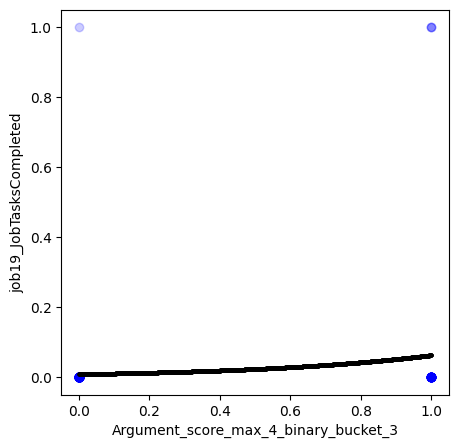

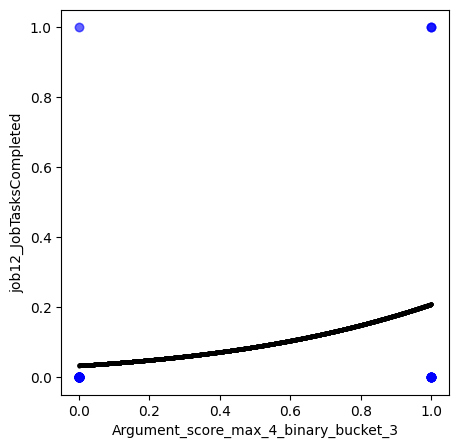

In [ ]:
pred = 'job19_JobTasksCompleted'
res = 'Argument_score_max_4_binary_bucket_3'

log_reg = smf.logit(f'{pred} ~ {res}', data=df).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df[res].min(), df[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df[res], df[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)

pred = 'job12_JobTasksCompleted'
res = 'Argument_score_max_4_binary_bucket_3'

log_reg = smf.logit(f'{pred} ~ {res}', data=df).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df[res].min(), df[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df[res], df[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)

Optimization terminated successfully.
         Current function value: 0.281333
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.188258
         Iterations 8


Text(0, 0.5, 'job13_JobTasksCompleted')

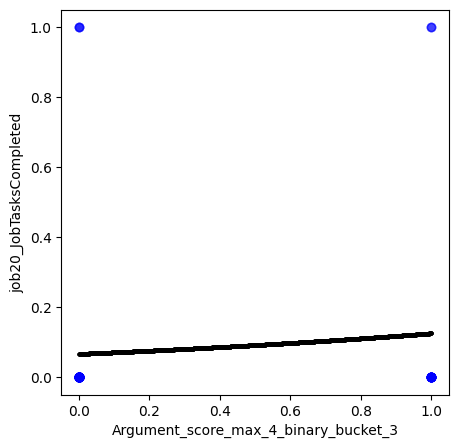

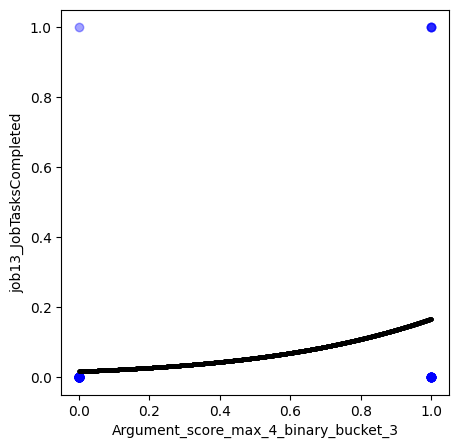

In [ ]:
pred = 'job20_JobTasksCompleted'
res = 'Argument_score_max_4_binary_bucket_3'

log_reg = smf.logit(f'{pred} ~ {res}', data=df).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df[res].min(), df[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df[res], df[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)


pred = 'job13_JobTasksCompleted'
res = 'Argument_score_max_4_binary_bucket_3'

log_reg = smf.logit(f'{pred} ~ {res}', data=df).fit()
compNew = pd.DataFrame({f'{res}': np.linspace(df[res].min(), df[res].max(), 2000)})
predProbs = log_reg.predict(compNew)

plt.figure(figsize=(5, 5))
ax = plt.axes()
ax.scatter(df[res], df[pred], color='b', alpha=0.20)
ax.scatter(compNew, predProbs , color="black", s=4)
ax.set_xlabel(res)
ax.set_ylabel(pred)



## Interpretation cont.

This kind of "filtering" effect could lend itself to some sort of decision tree model later on... up until this point I've been testing correlations between jobs and E/M/A outcomes as if jobs were independent. In reality it seems like we're actually dealing with many branches, a few (2) of which seem to lead to high probabilities of test outcomes.

We can see how as we go from the "outer" job to the "inner" job the dichotomy between jobTasksCompleted when argument is 0 vs 1 grows greater.

## Further Questions



*   We've found jobs that seem to predict argument scores and that also have a high argument difficulty- is there some other kind of test or feature engineering we can do to investigate this for modeling and experimentation?
*   What are the implications of the second test data set? If these tests are reproducible or not?
*  Are simple binary measures of job completed sufficient for this kind of analysis?
* We've been testing jobs independently of eachother, but are there certain combinations of jobs/paths that correlate to certain EMA outcomes?
* The two jobs we've identified, jobs 12 and 13, both exist within a larger domain of a required prereq job. Is there some behavior/feature within that job that we can find was present in players that also completed the primary job in the subdomain?
* Logistic regression is vulnerable to overfitting and cannot handle a large number of categorical variables. What other models can we use for further analysis?



# Decision Trees- the next step?

Given the natural "branch" structure of our levels in Wake it seems natural to use decision trees in this analysis. Decision tree algorithms recursively try to find the "purest" splits in the data between different nodes. Given the number of categorical features we should be sure to reduce our max-depth to avoid overfitting.

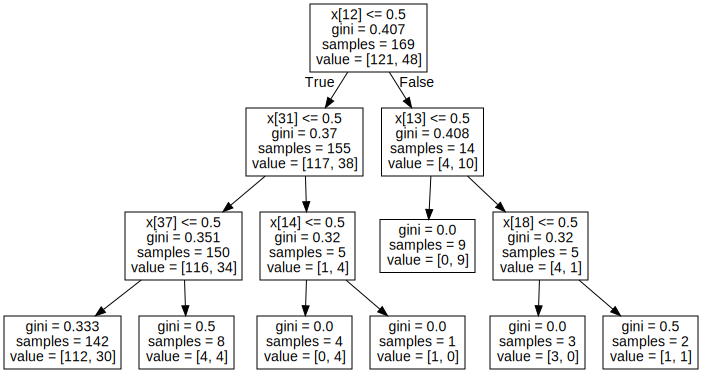

In [ ]:

# Assuming 'df' is your DataFrame
X, y = df, df['Argument_score_max_4_binary_bucket_3']

# Filter columns containing the word "job"
columns_with_job = [col for col in df.columns if 'jobtask' in col.lower() and '13' not in col.lower()]
X = df[columns_with_job]

X

clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X, y)

# tree.plot_tree(clf)

dot_data = tree.export_graphviz(clf, out_file=None)

graph = graphviz.Source(dot_data)

graph.render("exp_tree")
graph

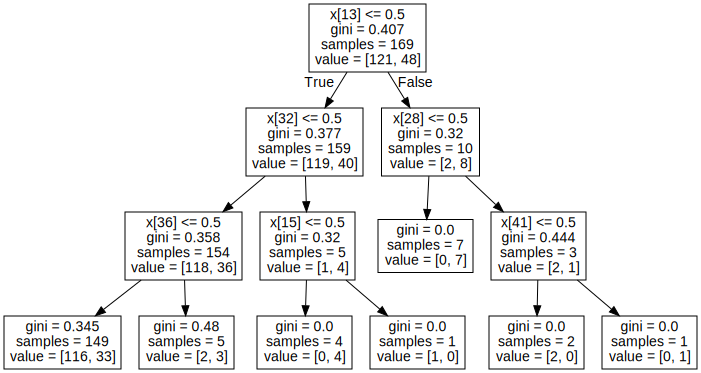

In [ ]:

# Assuming 'df' is your DataFrame
X, y = df, df['Argument_score_max_4_binary_bucket_3']

# Filter columns containing the word "job"
columns_with_job = [col for col in df.columns if 'jobtask' in col.lower()]
X = df[columns_with_job]

X

clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X, y)

# tree.plot_tree(clf)

dot_data = tree.export_graphviz(clf, out_file=None)

graph = graphviz.Source(dot_data)

graph.render("exp_tree")
graph

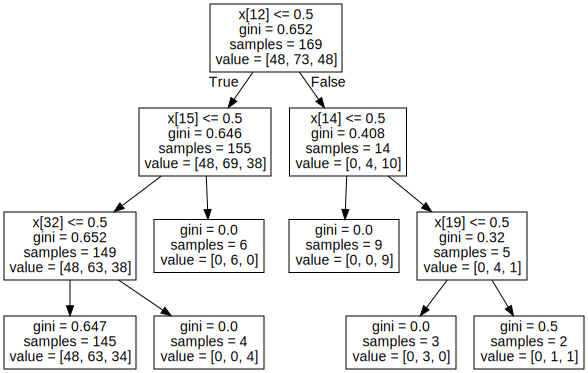

In [ ]:

# Assuming 'df' is your DataFrame
X, y = df, df['Argument_score_max_4_bucket_4']

# Filter columns containing the word "job"
columns_with_job = [col for col in df.columns if 'jobtask' in col.lower()]
X = df[columns_with_job]

X

clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(X, y)

# tree.plot_tree(clf)

dot_data = tree.export_graphviz(clf, out_file=None)

graph = graphviz.Source(dot_data)

graph.render("exp_tree")
graph

In [ ]:
## Load in feature values and columns from tsv

ply_features = pd.read_csv("/content/drive/MyDrive/AqualabValidation_Zach/featuredata/AQUALAB_20220601_to_20220715_c2ad3af_player-features.tsv", sep = "	").dropna()
#remove NA values
ply_features = ply_features.loc[ply_features.PlayerID.isna() != True]

id_col = ['PlayerID']
job_col = []
aggr_col = []
for col in ply_features.columns:
  pieces = col.split('_')
  prefix = pieces[0]
  if prefix.startswith('job'):
    job_col.append(pieces[1])
  else:
    aggr_col.append(col)
job_col = Counter(job_col)
print(f"{len(ply_features.columns)} perjobfeatures in {len(job_col)} groups:")
pprint(job_col, compact=False)

job_col = [key for key in job_col.keys() if key.startswith('Job')]
aggr_col = aggr_col[1:]
pprint(aggr_col)

df = ply_features
sum(df['job12_JobsAttempted-num-completes'])

1272 perjobfeatures in 22 groups:
Counter({'JobActiveTime': 57,
         'JobArgumentationTime': 57,
         'JobCompletionTime': 57,
         'JobDiveSitesCount': 57,
         'JobDiveTime': 57,
         'JobExperimentationTime': 57,
         'JobGuideCount': 57,
         'JobHelpCount': 57,
         'JobHelpCount-ByTask': 57,
         'JobLocationChanges': 57,
         'JobLocationChanges-ByTask': 57,
         'JobModelingTime': 57,
         'JobTasksCompleted': 57,
         'SyncCompletionTime': 57,
         'JobsAttempted': 57,
         'JobsAttempted-job-name': 57,
         'JobsAttempted-num-starts': 57,
         'JobsAttempted-num-completes': 57,
         'JobsAttempted-percent-complete': 57,
         'JobsAttempted-avg-time-per-attempt': 57,
         'JobsAttempted-std-dev-per-attempt': 57,
         'JobsAttempted-job-difficulties': 57})
['ActiveTime',
 'JobsCompleted',
 'SessionDiveSitesCount',
 'SessionDuration',
 'SessionGuideCount',
 'SessionHelpCount',
 'SessionID',
 'Ses

15.0